In [59]:
# imports
import os
import torch
import pandas as pd 
from skimage import io, transform
import numpy as np 
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.io import read_image
import PIL
from PIL import Image
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [28]:
root_dir = os.path.join(os.getcwd(), "data" )
root_dir

'g:\\Work\\BMW\\Workbench\\data'

In [61]:
def get_transform(train):
    if train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
            ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

torch.Size([400, 300, 3])

In [70]:
# Image Detection Class
class ImageDetection(Dataset):
    def __init__(self, root_dir, width, height, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.width = width
        self.height = height

        self.folders = os.listdir(root_dir)
        self.images = []
        self.json_data = []
        

        for folder in self.folders:
            folder_path = os.path.join(root_dir, folder)
            image_folder = os.path.join(folder_path, "images")
            json_folder = os.path.join(folder_path, "labels", "json")

            for file in os.listdir(image_folder):
                file_path = os.path.join(image_folder, file)
                self.images.append((file_path, folder))
            
            for file in os.listdir(json_folder):
                file_path = os.path.join(json_folder, file)
                self.json_data.append((file_path, folder))

    def images(self):
        return self.json_data

    def load_image(self, idx):
        img_file = self.images[idx][0]
        image = read_image(img_file)
        return Image.open(img_file).convert("RGB")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_file = self.images[idx][0]
        json_file = self.json_data[idx][0]


        #reading the images and coverting them to correct size and color
        img = cv2.imread(img_file)
        print(img.shape)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0

        print(img_res.shape)

        # read the json file / annotations
        df1 = pd.read_json(json_file)
       
        boxes = []
        labels = []

        wt = img.shape[1]
        ht = img.shape[0]

        pen_y  =  img_res.shape[0] / img.shape[0] 
        pen_x =  img_res.shape[1]  /img.shape[1] 

        print("pen_x", pen_x)
        print("pen_y", pen_y)

        for i in range(len(df1)):
            labels.append(df1["ObjectClassId"][i])
            print( [df1["Left"][i], df1["Top"][i], df1["Right"][i], df1["Bottom"][i]])
            print( [df1["Left"][i] * pen_y, df1["Top"][i] * pen_x, df1["Right"][i] * pen_y, df1["Bottom"][i] *pen_x])
            x1 = df1["Left"][i] *pen_x
            y1 = df1["Top"][i] * pen_y
            x2 = df1["Right"][i] * pen_x
            y2 = df1["Bottom"][i] * pen_y
            boxes.append([x1, y1, x2, y2])
        
        print("act boxes", boxes)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = torch.as_tensor(labels, dtype=torch.int64)
            
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area

        if self.transforms:
            sample = self.transforms(image = img_res, bboxes = target["boxes"], labels = labels)
            img_res = sample["image"]
            target["boxes"] = torch.Tensor(sample["bboxes"])

        return img_res, target


        # image_shape = image.shape
        # if self.transform:
        #     image = self.transform(image)
        #     transformed_image_shape = image.shape
      
        #     pen_x  =  transformed_image_shape[1] / image_shape[1] 
        #     pen_y =  transformed_image_shape[2]  /image_shape[2] 

        

        # for i in range(len(df1)):

        #     boxes = [df1["Left"][i] * pen_y, df1["Top"][i] * pen_x, df1["Right"][i] * pen_y, df1["Bottom"][i] *pen_x]
        #     boxes = torch.as_tensor(boxes, dtype=torch.float32)

        #     target = {}
        #     target["boxes"] = boxes
        #     target["labels"] = torch.as_tensor(df1["ObjectClassId"][i], dtype=torch.int64)
        #     target["image_id"] = torch.tensor([idx])
        #     target["area"] = (boxes[3] - boxes[1]) * (boxes[2] - boxes[0])
           
        #     return image, target
            #return image, df1["ObjectClassName"][i],  df1["ObjectClassId"][i] , df1["Id"][i] , df1["Left"][i] * pen_y, df1["Top"][i] * pen_x, df1["Right"][i] * pen_y, df1["Bottom"][i] *pen_x
            
# transform = transforms.Compose([
#     transforms.Resize(size=(64, 64)),
# ])
data_set = ImageDetection(root_dir, width=280, height=240, transforms=get_transform(train=True))
data_set.__getitem__(1) 



(720, 1280, 3)
(240, 280, 3)
pen_x 0.21875
pen_y 0.3333333333333333
[307, 187, 774, 685]
[102.33333333333333, 40.90625, 258.0, 149.84375]
act boxes [[67.15625, 62.33333333333333, 169.3125, 228.33333333333331]]


(array([[[0.15210083, 0.15210083, 0.15210083],
         [0.17002802, 0.17002802, 0.17002802],
         [0.17983194, 0.17983194, 0.17983194],
         ...,
         [0.48991597, 0.48991597, 0.48991597],
         [0.4420168 , 0.44985995, 0.44593838],
         [0.32689074, 0.3442577 , 0.33949578]],
 
        [[0.11344538, 0.11344538, 0.11344538],
         [0.14509805, 0.14509805, 0.14509805],
         [0.16078432, 0.16078432, 0.16078432],
         ...,
         [0.5016807 , 0.5016807 , 0.5016807 ],
         [0.4787115 , 0.48655462, 0.48263305],
         [0.41764706, 0.43333334, 0.42941177]],
 
        [[0.067507  , 0.067507  , 0.067507  ],
         [0.17310925, 0.17310925, 0.17310925],
         [0.14985995, 0.14985995, 0.14985995],
         ...,
         [0.49467787, 0.49467787, 0.49467787],
         [0.49663866, 0.5044818 , 0.5005602 ],
         [0.4697479 , 0.47759104, 0.47366947]],
 
        ...,
 
        [[0.3694678 , 0.3694678 , 0.36162466],
         [0.36890754, 0.36890754, 0.36106

(720, 1280, 3)
(240, 280, 3)
pen_x 0.21875
pen_y 0.3333333333333333
[307, 187, 774, 685]
[102.33333333333333, 40.90625, 258.0, 149.84375]
act boxes [[67.15625, 62.33333333333333, 169.3125, 228.33333333333331]]
Image Shape is Now  (240, 280, 3)


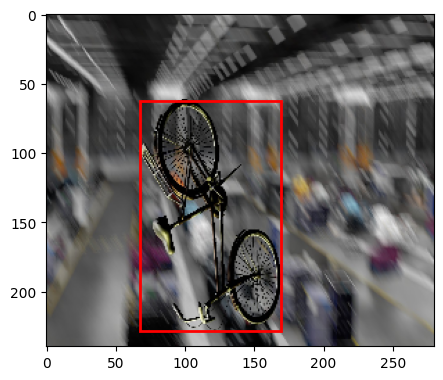

In [71]:
import matplotlib.patches as patches

def plot_image_and_boxes(image, target):
    print("Image Shape is Now " , image.shape)
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(image)
    # print("target boxes" , target["boxes"])
    for box in target["boxes"]:
        x, y , width, height  = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect  = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        a.add_patch(rect)
    plt.show()

image, target = data_set[1]
plot_image_and_boxes(image, target)


In [ ]:
def display_random_images(data_set, n = 10, display_shape = True, seed = None):

    if n > 10:
        n = 10
        display_shape = False
    
    if seed:
        np.random.seed(seed)
    
    random_sample_idx = np.random.randint(0, len(data_set), n)

    plt.figure(figsize=(16,8))

    for i,idx in enumerate(random_sample_idx):
        b_image, class_name, class_id, image_id , left, top, right, bottom = data_set.__getitem__(idx)

        targ_image_adjust = b_image.permute(1,2,0)

        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')

        title = f"Label: {class_name}"
        title = title + f"\nshape: {b_image.shape}"

        # matplotlib create bouding box from coordinates
        targ_bbox = [left, top, right, bottom]
        print(targ_bbox)
        rect = plt.Rectangle((left, top), right - left, bottom - top, fill=False, color='red')
        plt.gca().add_patch(rect)
        plt.title(title)
       

#display_random_images(data_set, 1, seed = 0)


In [ ]:
train_image, test_image = torch.utils.data.random_split(data_set, [int(len(data_set)*0.75), int(len(data_set)*0.25)+1])

BATCH_SIZE = 64
NUM_WORKERS = 0
train_image_data_loader = DataLoader(dataset=train_image, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_image_data_loader = DataLoader(dataset=test_image, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS )

type(train_image_data_loader)

torch.utils.data.dataloader.DataLoader

In [ ]:
for batch in train_image_data_loader:
    print(batch[1])
    break

('bicycle', 'cardboard_box', 'l_klt_6147', 'stillage_open', 'pallet', 'l_klt_6147', 'l_klt_4147', 'stillage_open', 'l_klt_4147', 'bicycle', 'l_klt_6147', 'str', 'l_klt_8210', 'l_klt_8210', 'pallet', 'l_klt_4147', 'stillage_open', 'pallet', 'l_klt_4147', 'jack', 'cardboard_box', 'l_klt_4147', 'stillage_close', 'stillage_open', 'str', 'stillage_open', 'l_klt_4147', 'l_klt_4147', 'l_klt_6147', 'exit_sign', 'l_klt_4147', 'l_klt_6147', 'pallet', 'str', 'spring_post', 'pallet', 'l_klt_4147', 'spring_post', 'stillage_close', 'l_klt_4147', 'stillage_close', 'l_klt_6147', 'l_klt_4147', 'l_klt_4147', 'spring_post', 'jack', 'l_klt_4147', 'pallet', 'bicycle', 'forklift', 'l_klt_6147', 'l_klt_4147', 'exit_sign', 'dolly', 'pallet', 'stillage_open', 'exit_sign', 'cabinet', 'pallet', 'l_klt_4147', 'jack', 'forklift', 'bicycle', 'pallet')


In [ ]:
torch.manual_seed(42)

In [ ]:
# Model 
from torch import nn
# create flatten model

flatten_model = nn.Flatten()

data_train , *snsa  = next(iter(train_image_data_loader))
print(data_train.shape)

x = data_train[0]

output = flatten_model(x)

print(f"shape before flatten: {x.shape}")
print(f"shape after flatten: {output.shape}")


torch.Size([64, 3, 64, 64])
shape before flatten: torch.Size([3, 64, 64])
shape after flatten: torch.Size([3, 4096])


In [ ]:
class SordiV0(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.layerstack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.Linear(hidden_units, output_shape)
        )

    
    def forward(self, x):
        return self.layerstack(x)
   

In [ ]:
torch.manual_seed(42)
model_0  = SordiV0(3*4096, 10, len(train_image_data_loader))
model_0

SordiV0(
  (layerstack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=693, bias=True)
  )
)

In [ ]:
dummy_x = torch.rand(64, 3, 64, 64)
model_0(dummy_x)

for batch in train_image_data_loader:
    print(batch[0].shape)
    break

torch.Size([64, 3, 64, 64])


In [ ]:
# set up loss , optimizer and evaluation metrics
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [ ]:
from timeit import default_timer as timer

def print_train_time(start_time, end_time, device:torch.device = None):
    total_time = end_time - start_time
    print(f"Total time on device:{device} {total_time:.2f} seconds")
    return total_time

In [ ]:
start_time = timer()

end_time = timer()
print_train_time(start_time, end_time, device=device)

Total time on device:cuda:0 0.00 seconds


5.370000144466758e-05

In [ ]:
# train 

from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_device = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n -------------------")

    train_loss = 0.0

    for batch , train_item in enumerate(train_image_data_loader):
       
        # print(len(train_item))
        
        model_0.train()
        print(train_item[0])
        y_pred = model_0(train_item[0])
        print(y_pred)

        break
        # loss = loss_func(y_pred, train_item[1:])
        # train_loss += loss.item()

        # optimizer.zero_grad()

        # loss.backward()

        # optimizer.step()

        # if batch % 400 == 0:
        #     print(f"Looked at Batch: {batch * len(X)} / {len(train_image_data_loader.dataset)}")
        
# train_loss = train_loss / len(train_image_data_loader)


# test_loss, test_acc  = 0,0
# model_0.eval()
# with torch.inference_mode():
#     for X_test , *y_test in test_image_data_loader:
        
#         test_pred = model_0(X_test)
#         test_loss += loss_func(test_pred, y_test)
#         # test_acc += accuracy_score(y_test, test_pred.argmax(dim=1))
    
#     test_loss = test_loss / len(test_image_data_loader)
#     # test_acc = test_acc / len(test_image_data_loader)

# print(f"Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")


# train_time_end_on_device = timer()
# print_train_time(train_time_start_on_device, train_time_end_on_device, device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
 -------------------
tensor([[[[ 56,  23,  26,  ...,  26,  23,   6],
          [100,  71,  60,  ...,  67,  66,  17],
          [ 96, 129, 101,  ...,  70,  70,  30],
          ...,
          [161, 167, 174,  ...,  95,  76,  78],
          [186, 187, 182,  ...,  84,  83,  91],
          [197, 199, 190,  ...,  52,  75,  68]],

         [[ 56,  23,  26,  ...,  26,  23,   6],
          [100,  71,  60,  ...,  67,  66,  17],
          [ 96, 129, 101,  ...,  70,  70,  30],
          ...,
          [128, 134, 141,  ...,  95,  76,  78],
          [152, 154, 152,  ...,  84,  83,  91],
          [166, 166, 159,  ...,  54,  76,  70]],

         [[ 56,  23,  24,  ...,  26,  23,   6],
          [100,  71,  60,  ...,  67,  66,  17],
          [ 96, 129, 101,  ...,  70,  70,  30],
          ...,
          [ 83,  92, 100,  ...,  95,  76,  78],
          [106, 107, 111,  ...,  84,  83,  91],
          [119, 115, 114,  ...,  53,  78,  69]]],


        [[[144, 153, 151,  ..., 117,  84,  88],
    

  0%|          | 0/3 [00:02<?, ?it/s]


RuntimeError: mat1 and mat2 must have the same dtype